In [1]:
!pip install transformers 
!pip install datasets
!pip install tokenizers
!pip install transformers[torch]
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 6.5 MB/s eta 0:00:0000:01
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.22.0
    Uninstalling accelerate-0.22.0:
      Successfully uninstalled accelerate-0.22.0


In [2]:
import pandas as pd
import re
import string
import torch
from sklearn.model_selection import train_test_split

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from transformers import Trainer, TrainingArguments

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [14]:
fPath = "/kaggle/input/unit-3-sentiment/"
df = pd.read_csv(fPath + "train.csv")

# drop rows with empty target
df = df[~df.Sentiment.isna()].reset_index(drop=True)
df.drop("Unnamed: 0", axis=1, inplace=True)

print(df.shape)
df.head(3)

(41155, 2)


,Text,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive


## preprocess

{'Neutral': 0, 'Positive': 1, 'Extremely Negative': 2, 'Negative': 3, 'Extremely Positive': 4}


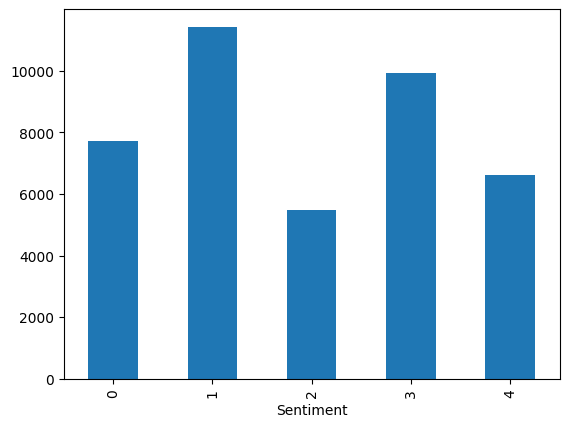

In [15]:
# encoding string labels
no_labels = df.Sentiment.nunique()
labels_dict = dict(zip(df.Sentiment.unique(), range(no_labels)))
print(labels_dict)
df.Sentiment = df.Sentiment.map(labels_dict)

# check the target ditribution
ax = df.groupby("Sentiment").count().plot(kind="bar", legend=False)

In [16]:
def remove_links(v):
    # remove https links
    return re.sub(r"https\S+","", v)

def remove_calls(v):
    # remove @text
    return re.sub(r"@\S+","", v)

def remove_punctuation(v):
    # remove special chars
    return re.sub(f"[{re.escape(string.punctuation)}]", '', v)

def remove_chars(v):
    # remove special chars
    chars = ["\n", "\t", "\r", "<br>"]
    for char in chars:
        v = v.replace(char, "")
    return v

def remove_digits(v):
    # remove digits
    return re.sub(r"\d", "", v)

def remove_emojis(data):
    # remove emojis
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

    
df.Text = df.Text.apply(remove_links)
df.Text = df.Text.apply(remove_calls)
df.Text = df.Text.apply(remove_punctuation)
df.Text = df.Text.apply(remove_chars)
df.Text = df.Text.apply(remove_digits)
df.Text = df.Text.apply(remove_emojis)

# lower the text
df.Text = df.Text.str.lower()
# remove rows with the text too short
min_text_len = 20
df = df[~df.Text.str.len()<min_text_len].reset_index(drop=True)
print("preprocess completed")

preprocess completed


In [17]:
xtr, xvl, ytr, yvl = train_test_split(df.Text, df.Sentiment, test_size=0.2, random_state=42)

xtr = xtr.reset_index(drop=True)
xvl = xvl.reset_index(drop=True)
ytr = ytr.reset_index(drop=True)
yvl = yvl.reset_index(drop=True)

print(xtr.shape, xvl.shape, ytr.shape, yvl.shape)

(32924,) (8231,) (32924,) (8231,)


## fit the model

In [19]:
#@title tokenize data

model_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_id)

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx])
        }
        return item

    def __len__(self):
        return len(self.labels)

train_tokenized = tokenizer(list(xtr), padding='max_length', truncation=True, max_length=128, return_tensors='pt')
eval_tokenized = tokenizer(list(xvl), padding='max_length', truncation=True, max_length=128, return_tensors='pt')

train_dataset = CustomDataset(train_tokenized, ytr)
eval_dataset = CustomDataset(test_tokenized, yvl)

In [20]:

!mkdir data

OUTPUT_DIR = "/kaggle/working/model"

model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=no_labels)
data_collator = DataCollatorWithPadding(tokenizer)

train_args = TrainingArguments(
    output_dir = OUTPUT_DIR,
)

trainer = Trainer(
    model=model,
    args=train_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset
)

trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
mkdir: cannot create directory ‘data’: File exists


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
500,1.146500
1000,0.793500
1500,0.697500
2000,0.629600
2500,0.485300
3000,0.438100
3500,0.416200
4000,0.399900
4500,0.303000
5000,0.259200


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=6174, training_loss=0.49564704363655804, metrics={'train_runtime': 1846.272, 'train_samples_per_second': 53.498, 'train_steps_per_second': 3.344, 'total_flos': 6497176291863552.0, 'train_loss': 0.49564704363655804, 'epoch': 3.0})

In [19]:
!mkdir kaggle/working/model

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
mkdir: cannot create directory ‘kaggle/working/model’: No such file or directory


In [20]:
trainer.save_model(OUTPUT_DIR)
OUTPUT_DIR = OUTPUT_DIR = "/kaggle/working/model"
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR) 

In [24]:
if False:
    from IPython.display import FileLink
    FileLink(r'file.zip')

/kaggle/working/file.zip

## predict text

In [37]:
# read test
df_test = pd.read_csv(fPath + "test.csv")

# preprocess test
df_test.Text = df_test.Text.apply(remove_links)
df_test.Text = df_test.Text.apply(remove_calls)
df_test.Text = df_test.Text.apply(remove_punctuation)
df_test.Text = df_test.Text.apply(remove_chars)
df_test.Text = df_test.Text.apply(remove_digits)
df_test.Text = df_test.Text.apply(remove_emojis)
df_test.Text = df_test.Text.str.lower()


In [53]:
# get predictions

all_labels = []
for i in range(len(df_test)//20+1): # due to RAM limitations
    
    input_text = df_test.Text.iloc[i*20:(1+i)*20].tolist()
    input_tokenized = tokenizer(input_text, padding='max_length', truncation=True, max_length=128, return_tensors='pt').to(device)
    with torch.no_grad():
        output = model(**input_tokenized)
    logits = output.logits
    predicted_probabilities = torch.softmax(logits, dim=1)
    predicted_labels = torch.argmax(predicted_probabilities, dim=1)
    predicted_labels = predicted_labels.tolist()
    all_labels.append(predicted_labels)
    
all_labels = [l for sl in all_labels for l in sl]

In [71]:
# decode labels
decode_labels_dict = {k:v for v,k in labels_dict.items()} 
all_labels = [decode_labels_dict[x] for x in all_labels]
# submit
submission = pd.read_csv(fPath + "sample_submission.csv")
submission.Sentiment = all_labels
submission.to_csv("data/submission.csv", index=False)

In [86]:
# import os
# os.environ["KAGGLE_USERNAME"]=
# os.environ["KAGGLE_KEY"]=

In [87]:
!kaggle competitions submit -c unit-3-nlp-txt-classification -f data/submission.csv -m "*"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|████████████████████████████████████████| 181k/181k [00:02<00:00, 88.2kB/s]
Successfully submitted to Unit 3 - Классификация текстов

In [84]:
!ls data

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
sample_submission.csv  submission.csv


In [75]:
!kaggle competitions submit -c h-and-m-personalized-fashion-recommendations  -f ../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv -m "Submission via API"